In [1]:
import pandas as pd
train1= pd.read_csv('severity2.csv')

In [2]:
train1.shape

(76523, 8913)

In [3]:
Train1=train1[(True-train1['Total_Incurred'].isin(['NaN']))]
Train1 = Train1.drop(['Policynumber','Claim_Count','Blame','Unnamed: 0'], axis = 1)
print(Train1.shape)

/Users/wujiexi/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '-' operator is not supported by numexpr for the bool dtype, use '^' instead
  unsupported[op_str]))


(7186, 8909)


In [4]:
Train1['Total_Incurred']

456         83.12
472          0.00
475          0.00
704          0.00
734          0.00
747         92.29
749        103.60
796         95.11
816       4597.06
888       1910.04
912         72.49
928        269.10
936          0.00
941          0.00
1046         0.00
1057         0.00
1069         0.00
1101      2497.16
1148       120.13
1151       148.88
1154         0.00
1201       154.91
1248         0.00
1252         0.00
1270       153.91
1320        94.77
1343         0.00
1357         0.00
1399      2209.17
1417        83.44
           ...   
75613      500.00
75623     1316.00
75629        0.00
75634     8224.00
75655      245.60
75658      161.63
75665        0.00
75679       64.01
75695       96.20
75708       96.00
75723     6125.50
75729    22674.00
75743        0.00
75777    10049.61
75794        0.00
75817     3743.65
75823     2000.00
75861        0.00
75868       49.42
75882     8410.00
75886       95.11
75888        0.00
75932     8524.00
76092     1576.00
76296     

In [5]:
Train1 =Train1.fillna('0')
TrainX = Train1.drop(['Total_Incurred'],axis=1)
import numpy as np
X = np.array(TrainX)
y = np.array (Train1.Total_Incurred)
print (X.shape)
print (y.shape)

(7186, 8908)
(7186,)


In [6]:
from sklearn.cross_validation import train_test_split
X_train_unproc, X_test_unproc,y_train, y_test = train_test_split(X,y,test_size=0.3)

/Users/wujiexi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,max_depth=10, random_state=10, loss='ls').fit(X_train_unproc,y_train)

In [8]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, est.predict(X_test_unproc))

3468.1241635849756

In [9]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test,est.predict(X_test_unproc))
rmse = math.sqrt(mse)
print(rmse)
print(mse)

5376.981922776616
28911934.5979


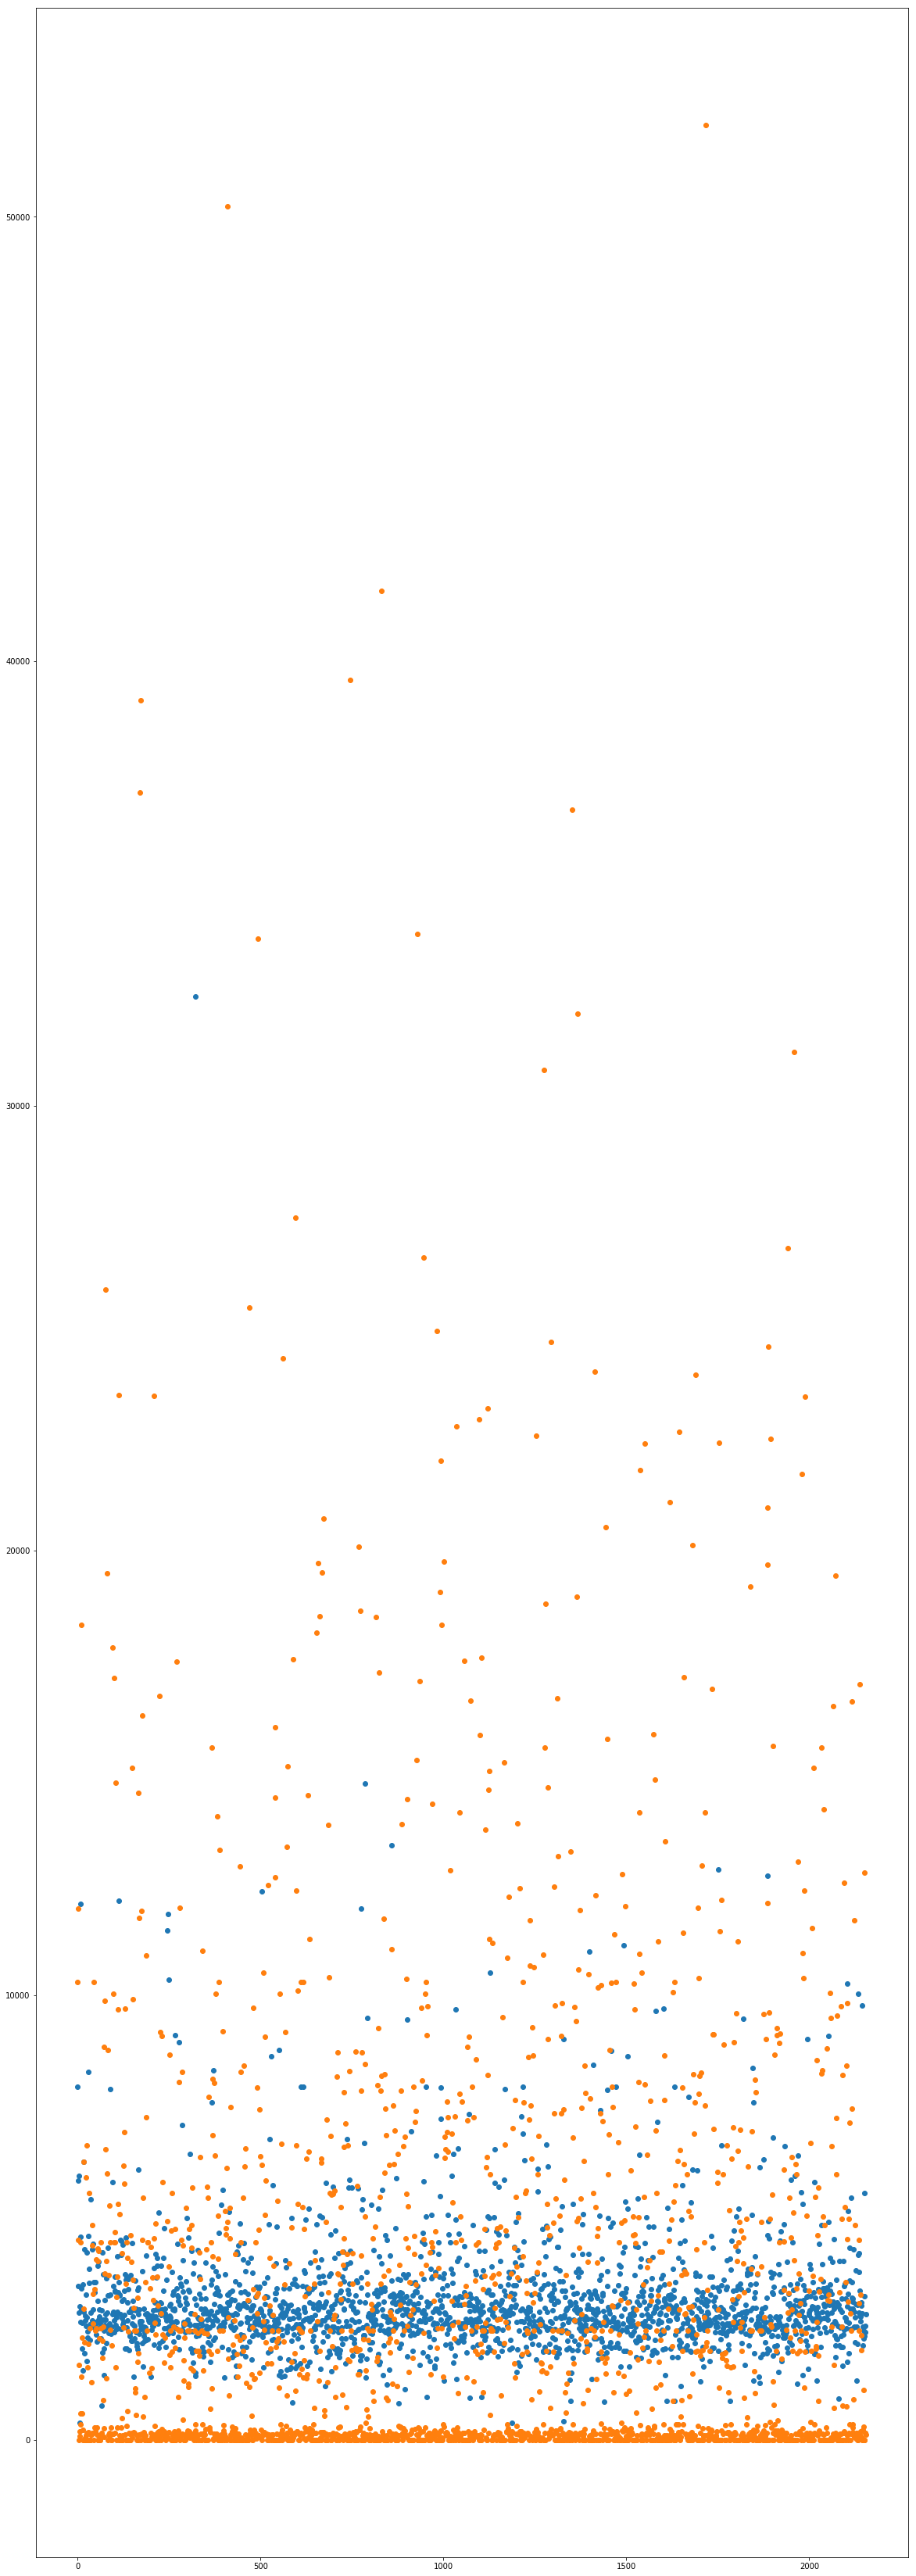

In [11]:
import matplotlib.pyplot as plt
x_ = np.arange(len(y_test))
plt.figure(num='Comparision',figsize=(20,60))
plt.scatter(x_,est.predict(X_test_unproc))
plt.scatter(x_,y_test)
plt.show()

In [70]:
from sklearn import tree
tree_re = tree.DecisionTreeRegressor(max_depth=10,min_samples_split=10,splitter='random')
tree_re = tree_re.fit(X_train_unproc,y_train)

In [71]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, tree_re.predict(X_test_unproc))

3469.5757157738972

In [72]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test,tree_re.predict(X_test_unproc))
rmse = math.sqrt(mse)
print(rmse)
print(mse)

5422.1533413477555
29399746.8571


In [73]:
import xgboost as xgb
x_train = xgb.DMatrix(X_train_unproc, y_train)
x_valid = xgb.DMatrix(X_test_unproc, y_test)

In [88]:
params = {}
params['objective'] = 'reg:tweedie'
params['eta'] = 0.07
params['silent'] = True
params['max_depth'] = 9
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8

In [75]:
def gini(actual,pred,cmpcol = 0,sortcol = 1):
    assert(len(actual)== len(pred))
    all = np.asarray(np.c_[actual,pred,np.arange(len(actual))],dtype = np.float)
    all = all[np.lexsort((all[:,2],-1*all[:,1]))]
    totallosses = all[:,0].sum()
    ginisum = all[:,0].cumsum().sum()/totallosses
    
    ginisum -= (len(actual)+1)/2
    return ginisum/len(actual)
def gini_normalized(a,p):
    return gini(a,p)/gini(a,a)
def gini_xgb(preds,dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels,preds)
    return [("gini",gini_score)]

In [89]:
watchlist = [(x_train, 'train'), (x_valid, 'valid')]
model_xgb = xgb.train(params, x_train, 300, watchlist,
                      feval=gini_xgb, early_stopping_rounds=250, maximize=True, verbose_eval=10)

[0]	train-tweedie-nloglik@1.5:4534.39	valid-tweedie-nloglik@1.5:4597.26	train-gini:-0.005914	valid-gini:-0.012136
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 250 rounds.
[10]	train-tweedie-nloglik@1.5:2261.06	valid-tweedie-nloglik@1.5:2307.14	train-gini:0.005724	valid-gini:-0.002172
[20]	train-tweedie-nloglik@1.5:1141.9	valid-tweedie-nloglik@1.5:1170.35	train-gini:0.029228	valid-gini:0.012136
[30]	train-tweedie-nloglik@1.5:598.939	valid-tweedie-nloglik@1.5:618.62	train-gini:0.211145	valid-gini:0.130202
[40]	train-tweedie-nloglik@1.5:351.816	valid-tweedie-nloglik@1.5:370.418	train-gini:0.343019	valid-gini:0.136852
[50]	train-tweedie-nloglik@1.5:253.255	valid-tweedie-nloglik@1.5:274.419	train-gini:0.540591	valid-gini:0.152987
[60]	train-tweedie-nloglik@1.5:218.088	valid-tweedie-nloglik@1.5:245.607	train-gini:0.711992	valid-gini:0.114212
[70]	train-tweedie-nloglik@1.5:206.148	valid-tweedie-nloglik@1.

In [91]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, model_xgb.predict(x_valid))
rmse = math.sqrt(mse)
print(rmse)
print(mse)

5422.1533413477555
29399746.8571


In [92]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, model_xgb.predict(x_valid))

3137.8979819940769

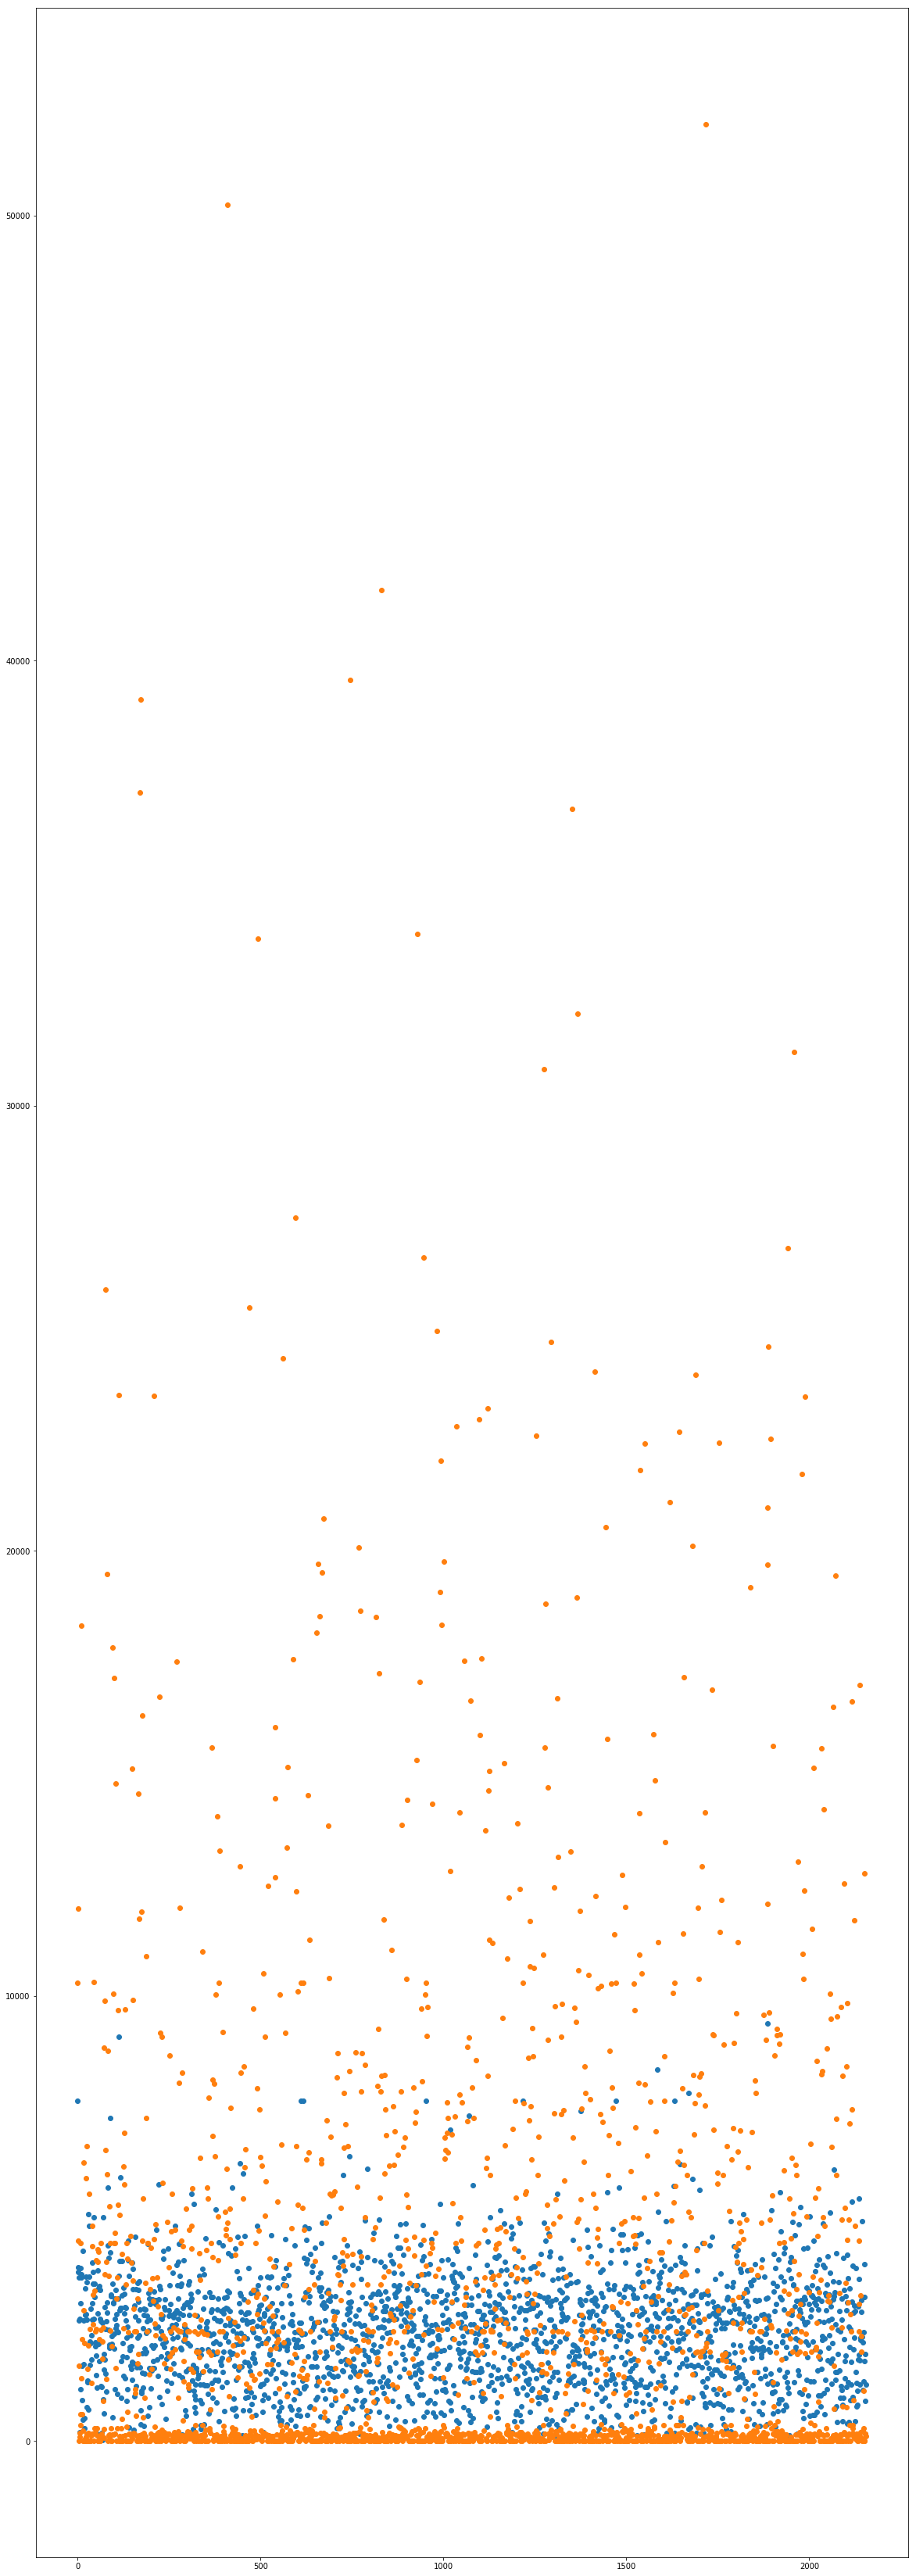

In [82]:
import matplotlib.pyplot as plt
x_ = np.arange(len(y_test))
plt.figure(num='Comparision',figsize=(20,60))
plt.scatter(x_,model_xgb.predict(x_valid))
plt.scatter(x_,y_test)
plt.show()

In [100]:
import time
start = time.time()
model = xgb.XGBRegressor(learning_rate = 0.07, n_estimators = 150,objective='reg:tweedie')
model.fit(X_train_unproc, y_train, eval_set=[(X_train_unproc, y_train), (X_test_unproc, y_test)])

print("Took {} seconds.".format(time.time() - start))

[0]	validation_0-tweedie-nloglik@1.5:4534.38	validation_1-tweedie-nloglik@1.5:4593.89
[1]	validation_0-tweedie-nloglik@1.5:4228.58	validation_1-tweedie-nloglik@1.5:4285.17
[2]	validation_0-tweedie-nloglik@1.5:3943.5	validation_1-tweedie-nloglik@1.5:3997.42
[3]	validation_0-tweedie-nloglik@1.5:3677.75	validation_1-tweedie-nloglik@1.5:3729.24
[4]	validation_0-tweedie-nloglik@1.5:3430.02	validation_1-tweedie-nloglik@1.5:3479.19
[5]	validation_0-tweedie-nloglik@1.5:3199.12	validation_1-tweedie-nloglik@1.5:3246.06
[6]	validation_0-tweedie-nloglik@1.5:2983.89	validation_1-tweedie-nloglik@1.5:3029.32
[7]	validation_0-tweedie-nloglik@1.5:2783.29	validation_1-tweedie-nloglik@1.5:2826.69
[8]	validation_0-tweedie-nloglik@1.5:2596.33	validation_1-tweedie-nloglik@1.5:2636.91
[9]	validation_0-tweedie-nloglik@1.5:2422.1	validation_1-tweedie-nloglik@1.5:2461.12
[10]	validation_0-tweedie-nloglik@1.5:2259.74	validation_1-tweedie-nloglik@1.5:2296.14
[11]	validation_0-tweedie-nloglik@1.5:2108.46	validatio

[95]	validation_0-tweedie-nloglik@1.5:216.692	validation_1-tweedie-nloglik@1.5:223.477
[96]	validation_0-tweedie-nloglik@1.5:216.589	validation_1-tweedie-nloglik@1.5:223.471
[97]	validation_0-tweedie-nloglik@1.5:216.506	validation_1-tweedie-nloglik@1.5:223.484
[98]	validation_0-tweedie-nloglik@1.5:216.404	validation_1-tweedie-nloglik@1.5:223.452
[99]	validation_0-tweedie-nloglik@1.5:216.327	validation_1-tweedie-nloglik@1.5:223.448
[100]	validation_0-tweedie-nloglik@1.5:216.273	validation_1-tweedie-nloglik@1.5:223.484
[101]	validation_0-tweedie-nloglik@1.5:216.183	validation_1-tweedie-nloglik@1.5:223.477
[102]	validation_0-tweedie-nloglik@1.5:216.133	validation_1-tweedie-nloglik@1.5:223.426
[103]	validation_0-tweedie-nloglik@1.5:216.064	validation_1-tweedie-nloglik@1.5:223.421
[104]	validation_0-tweedie-nloglik@1.5:216.011	validation_1-tweedie-nloglik@1.5:223.391
[105]	validation_0-tweedie-nloglik@1.5:215.981	validation_1-tweedie-nloglik@1.5:223.388
[106]	validation_0-tweedie-nloglik@1.

In [101]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, model.predict(X_test_unproc))

3358.6429072576461

In [102]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test,model.predict(X_test_unproc))
rmse = math.sqrt(mse)
print(rmse)
print(mse)

5260.20468510317
27669753.3292


In [ ]:
#### neural network baseline
model = Sequential()  
model.add(Dense(input_dim = X_train.shape[1],units = 1000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))
  
# 选定loss函数和优化器 
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(loss='mse', optimizer='adam')
model.summary()